In [69]:
# Imports
import pandas as pd
import os
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    make_scorer,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from scipy.stats import uniform, randint

# Paths

In [12]:
tables = "/arc/home/heestersnick/dwarforge/tables"
models = "/arc/home/heestersnick/dwarforge/models"
data_dir = "/arc/projects/unions/ssl/data/raw/tiles/dwarforge"
training_data_file = "umap_data_master.parquet"
if training_data_file.endswith(".csv"):
    training_data = pd.read_csv(os.path.join(tables, training_data_file))
elif training_data_file.endswith(".parquet"):
    training_data = pd.read_parquet(os.path.join(tables, training_data_file))
    training_data["lsb_cfis_lsb-r"] = training_data["lsb_cfis_lsb-r"].fillna(0)
    training_data.rename(columns={"lsb_cfis_lsb-r": "lsb"}, inplace=True)
    training_data.drop(columns=["lsb_whigs-g"], inplace=True)
    training_data.drop(columns=["lsb_ps-i"], inplace=True)

# Functions

In [59]:
def plot_confusion_matrix(
    y_true, y_pred, labels, title="Confusion Matrix", cmap="viridis"
):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    gs = plt.GridSpec(
        len(labels), len(labels) + 1, width_ratios=[4] * len(labels) + [0.1]
    )
    plt.figure(figsize=(len(labels) + 3, len(labels) + 3))
    ax = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar_kws={"shrink": 0.805},
        square=True,
        xticklabels=labels,
        yticklabels=labels,
    )

    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                ax.text(
                    j + 0.5,
                    i + 0.5,
                    f"{cm[i, j]:d}\n{cm_percentage[i, j]:.1f}%",
                    ha="center",
                    va="center",
                    fontsize=10,
                    color="black",
                )
            else:
                ax.text(
                    j + 0.5,
                    i + 0.5,
                    f"{cm[i, j]:d}\n{cm_percentage[i, j]:.1f}%",
                    ha="center",
                    va="center",
                    fontsize=10,
                    color="white",
                )

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    # plt.savefig('/home/nick/Documents/Candidacy_Exam/Presentation/Figures/'+'cm_w_percentage.png', bbox_inches='tight', dpi=300)
    plt.show()


def classify_and_save_parquet(
    parent_folder, random_forest_model, features, df_path_out, band="cfis_lsb-r"
):
    pattern = os.path.join(
        parent_folder, "*_*", band, "CFIS_LSB.*.r_rebin_det_params.parquet"
    )
    positive_class_rows = []
    for file in tqdm(glob(pattern)):
        try:
            filename = os.path.basename(file)
            tile_numbers = filename.split(".")[1:3]
            tile_id = f"({tile_numbers[0]}, {tile_numbers[1]})"

            # Read the parquet file
            df = pd.read_parquet(file)

            # Select only the columns used for inference
            X = df[features]

            # Apply the random forest model
            df["class"] = random_forest_model.predict(X)

            # Aggregate rows where class = 1
            positive_rows = df[df["class"] == 1].copy()
            positive_rows["tile"] = tile_id  # Add file path for reference
            positive_class_rows.append(positive_rows)

            # Save the updated dataframe back to parquet
            df.to_parquet(file, index=False)

        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue

    # Combine all positive class rows into a single DataFrame
    if positive_class_rows:
        all_positive_rows = pd.concat(positive_class_rows, ignore_index=True)
        all_positive_rows.to_parquet(df_path_out, index=False)
    else:
        all_positive_rows = pd.DataFrame()

    return all_positive_rows


def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Additional metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    balanced_accuracy = (recall + specificity) / 2

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Average Precision (AP) summarizes a precision-recall curve
    average_precision = average_precision_score(y_test, y_pred_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")

    plot_confusion_matrix(y_test, y_pred, labels=["no dwarf", "dwarf"])

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Precision-Recall curve: AP={average_precision:0.2f}")
    plt.show()

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve")
    plt.show()


def sample_and_shuffle_data(df, label_column="lsb", neg_pos_ratio=3, random_state=42):
    # Separate positive and negative examples
    positive_df = df[df[label_column] == 1]
    negative_df = df[df[label_column] == 0]

    # Calculate the number of negative examples to keep
    n_positive = len(positive_df)
    n_negative_to_keep = n_positive * neg_pos_ratio

    # Sample negative examples
    if len(negative_df) > n_negative_to_keep:
        negative_sample = negative_df.sample(
            n=int(n_negative_to_keep), random_state=random_state
        )
    else:
        negative_sample = negative_df  # Keep all if we don't have enough

    # Combine positive examples with sampled negative examples
    combined_df = pd.concat([positive_df, negative_sample])

    # Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    return shuffled_df

def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Additional metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    balanced_accuracy = (recall + specificity) / 2

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Average Precision (AP) summarizes a precision-recall curve
    average_precision = average_precision_score(y_test, y_pred_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")

    plot_confusion_matrix(y_test, y_pred, labels=["no dwarf", "dwarf"])

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Precision-Recall curve: AP={average_precision:0.2f}")
    plt.show()

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve")
    plt.show()

# Data loading

In [107]:
# features = ['total_flux', 'mu_max', 'mu_median', 'mu_mean', 'n_pix', 're_arcsec', 'r_fwhm_arcsec', 'r_10_arcsec', 'r_25_arcsec', 'r_75_arcsec', 'r_90_arcsec', 'r_100_arcsec', 'A_arcsec', 'B_arcsec', 'axis_ratio', 'mag', 'mu', 'lsb']
features = [
    #"total_flux_cfis_lsb-r",
    #"mu_max_cfis_lsb-r",
    #"mu_median_cfis_lsb-r",
    #"mu_mean_cfis_lsb-r",
    "re_arcsec_cfis_lsb-r",
    #"r_fwhm_arcsec_cfis_lsb-r",
    "r_10_arcsec_cfis_lsb-r",
    "r_25_arcsec_cfis_lsb-r",
    "r_75_arcsec_cfis_lsb-r",
    "r_90_arcsec_cfis_lsb-r",
    #"r_100_arcsec_cfis_lsb-r",
    "axis_ratio_cfis_lsb-r",
    "mag_cfis_lsb-r",
    "mu_cfis_lsb-r",
    #"total_flux_whigs-g",
    # "mu_max_whigs-g",
    # "mu_median_whigs-g",
    # "mu_mean_whigs-g",
    "re_arcsec_whigs-g",
    # "r_fwhm_arcsec_whigs-g",
    "r_10_arcsec_whigs-g",
    "r_25_arcsec_whigs-g",
    "r_75_arcsec_whigs-g",
    "r_90_arcsec_whigs-g",
    # "r_100_arcsec_whigs-g",
    # "axis_ratio_whigs-g",
    "mag_whigs-g",
    "mu_whigs-g",
    # "total_flux_ps-i",
    # "mu_max_ps-i",
    # "mu_median_ps-i",
    # "mu_mean_ps-i",
    "re_arcsec_ps-i",
    # "r_fwhm_arcsec_ps-i",
    "r_10_arcsec_ps-i",
    "r_25_arcsec_ps-i",
    "r_75_arcsec_ps-i",
    "r_90_arcsec_ps-i",
    # "r_100_arcsec_ps-i",
    # "axis_ratio_ps-i",
    "mag_ps-i",
    "mu_ps-i",
    "lsb",
]
dwarf_column = "lsb"
training_df = training_data[features]
training_df = sample_and_shuffle_data(training_df, neg_pos_ratio=4.0)
X, y = training_df.drop(columns=[dwarf_column]), training_df[dwarf_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=np.random.randint(99)
)
print(
    f"Using {len(training_df)} examples. {np.count_nonzero(y == 1)} positive and {np.count_nonzero(y==0)} negative ones."
)
print(f"{len(X_train)} are used for training, {len(X_test)} for testing.")

Using 5230 examples. 1046 positive and 4184 negative ones.
4184 are used for training, 1046 for testing.


# XGBoost

In [108]:
# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

# # Define the parameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [100, 200],
#     'min_child_weight': [1, 5],
#     'gamma': [0, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }


# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_grid,
#     n_iter=20,  # number of parameter settings that are sampled
#     scoring=make_scorer(accuracy_score),
#     cv=3,  # reduced from 5 to 3
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

scale_pos_weight = 2.0

param_grid = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': [scale_pos_weight, 1]  # Try both weighted and unweighted
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # number of parameter settings that are sampled
    scoring=make_scorer(roc_auc_score),
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


In [109]:
# Fit the grid search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.8675365010654429, gamma=0.33296117830874833, learning_rate=0.18738933631231813, max_depth=8, min_child_weight=3, n_estimators=838, scale_pos_weight=2.0, subsample=0.9886848381556415; total time=   0.7s
[CV] END colsample_bytree=0.8675365010654429, gamma=0.33296117830874833, learning_rate=0.18738933631231813, max_depth=8, min_child_weight=3, n_estimators=838, scale_pos_weight=2.0, subsample=0.9886848381556415; total time=   0.7s
[CV] END colsample_bytree=0.9395655297064336, gamma=0.3608647605824366, learning_rate=0.08079547592468672, max_depth=8, min_child_weight=7, n_estimators=894, scale_pos_weight=2.0, subsample=0.8842651558743149; total time=   1.1s
[CV] END colsample_bytree=0.9395655297064336, gamma=0.3608647605824366, learning_rate=0.08079547592468672, max_depth=8, min_child_weight=7, n_estimators=894, scale_pos_weight=2.0, subsample=0.8842651558743149; total time=   1.1s
[CV] END colsample_b

In [ ]:
# Evaluate on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion matrix

Accuracy: 0.9343
Precision: 0.8703
Recall (Sensitivity): 0.8966
Specificity: 0.9488
F1 Score: 0.8832
Balanced Accuracy: 0.9227
ROC AUC: 0.9719
Average Precision: 0.9327


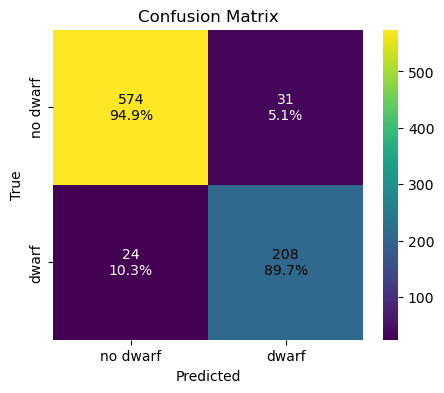

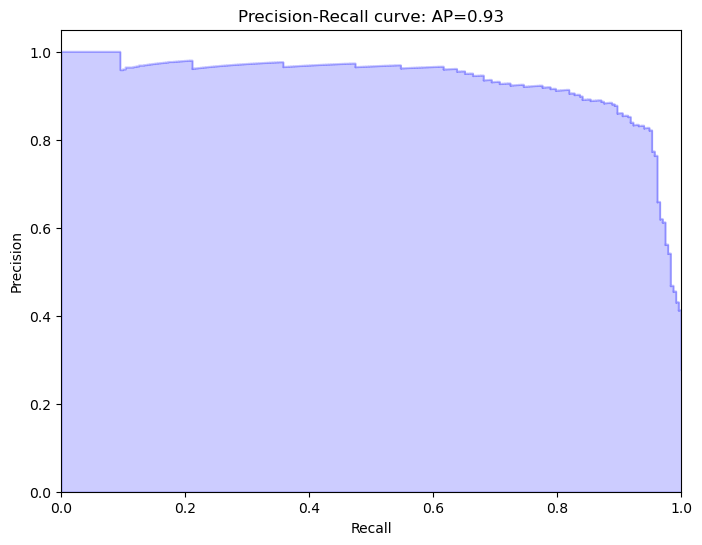

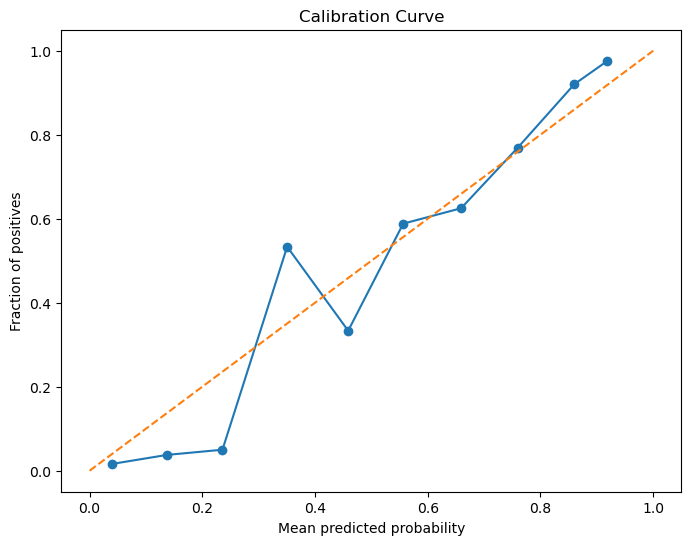

In [106]:
evaluate_model(best_model, X_test, y_test)